In [14]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [26]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wih = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bi = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        #forget gate
        ##################### TO DO #####################
        self.Wfx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wfh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bf = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        #c gate
        ##################### TO DO #####################
        self.Wcx =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Wch = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bc = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        #output gate
        ##################### TO DO #####################
        self.Wox =  Parameter(torch.Tensor(hiddensz, inputsz)) ##################### TO DO #####################
        self.Woh = Parameter(torch.Tensor(hiddensz, hiddensz)) ##################### TO DO #####################
        self.bo = Parameter(torch.Tensor(hiddensz, 1)) ##################### TO DO #####################
        
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht = torch.zeros(hiddensz, 1) ##################### TO DO #####################
            ct = torch.zeros(hiddensz, 1) ##################### TO DO #####################
        
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it =   torch.sigmoid(self.Wix @ xt + self.Wih @ ht + self.bi)
            ft =   torch.sigmoid(self.Wfx @ xt + self.Wfh @ ht + self.bf)
            gt =   torch.tanh(   self.Wcx @ xt + self.Wch @ ht + self.bc)
            ot =   torch.sigmoid(self.Wox @ xt + self.Woh @ ht + self.bo)
            ct =   (ft * ct) + (it * gt)
            ht =   ot * torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [27]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [28]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [29]:
addData(20)

(tensor([[-0.3734,  0.0000],
         [ 0.1274,  0.0000],
         [-0.0526,  0.0000],
         [-0.0238,  0.0000],
         [-0.4918,  0.0000],
         [-0.4403,  0.0000],
         [ 0.2689,  0.0000],
         [ 0.0179,  0.0000],
         [-0.2337,  1.0000],
         [-0.2415,  1.0000],
         [-0.0646,  0.0000],
         [-0.3979,  0.0000],
         [ 0.2533,  0.0000],
         [ 0.4102,  0.0000],
         [-0.0740,  0.0000],
         [ 0.3794,  0.0000],
         [ 0.2822,  0.0000],
         [ 0.4087,  0.0000],
         [ 0.2231,  0.0000],
         [-0.2477,  0.0000]]), tensor(-0.4752))

In [30]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [31]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [32]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

/home/tim/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.4375,val Loss: 0.1353
Epoch: 2/100............. training: 0.1117,val Loss: 0.1707
Epoch: 3/100............. training: 0.1088,val Loss: 0.1569
Epoch: 4/100............. training: 0.1057,val Loss: 0.1488
Epoch: 5/100............. training: 0.1048,val Loss: 0.1483
Epoch: 6/100............. training: 0.1039,val Loss: 0.1490
Epoch: 7/100............. training: 0.1032,val Loss: 0.1491
Epoch: 8/100............. training: 0.1025,val Loss: 0.1490
Epoch: 9/100............. training: 0.1019,val Loss: 0.1490
Epoch: 10/100............. training: 0.1015,val Loss: 0.1490
Epoch: 11/100............. training: 0.1010,val Loss: 0.1490
Epoch: 12/100............. training: 0.1007,val Loss: 0.1491
Epoch: 13/100............. training: 0.1003,val Loss: 0.1491
Epoch: 14/100............. training: 0.1000,val Loss: 0.1491
Epoch: 15/100............. training: 0.0998,val Loss: 0.1491
Epoch: 16/100............. training: 0.0995,val Loss: 0.1491
Epoch: 17/100............. traini

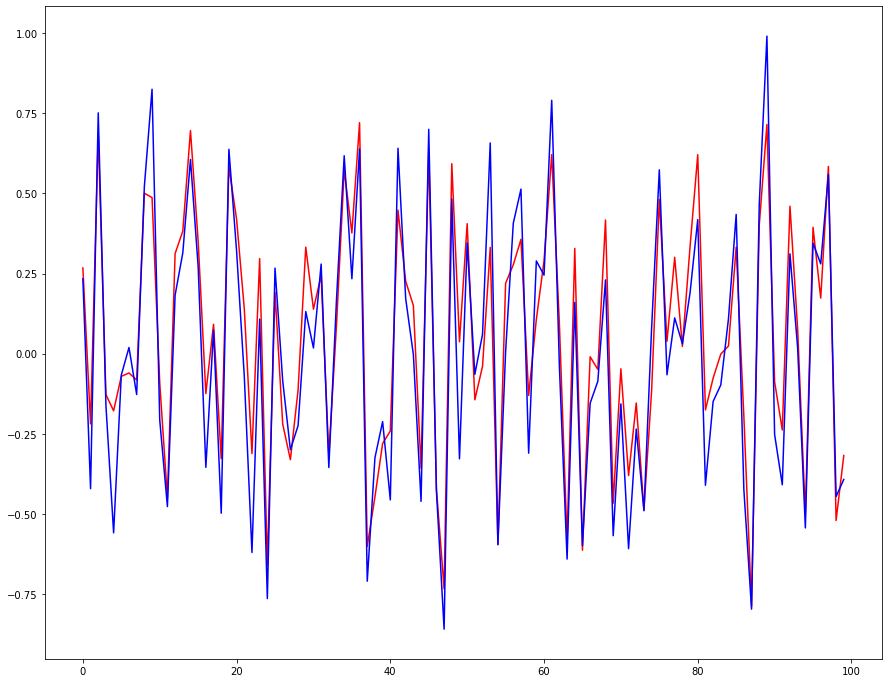

In [33]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [34]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [35]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [36]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [37]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


/home/tim/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.0483,val Loss: 0.0627
Epoch: 2/100............. training: 0.0442,val Loss: 0.0598
Epoch: 3/100............. training: 0.0453,val Loss: 0.0596
Epoch: 4/100............. training: 0.0449,val Loss: 0.0594
Epoch: 5/100............. training: 0.0445,val Loss: 0.0589
Epoch: 6/100............. training: 0.0443,val Loss: 0.0585
Epoch: 7/100............. training: 0.0441,val Loss: 0.0582
Epoch: 8/100............. training: 0.0439,val Loss: 0.0578
Epoch: 9/100............. training: 0.0437,val Loss: 0.0575
Epoch: 10/100............. training: 0.0436,val Loss: 0.0571
Epoch: 11/100............. training: 0.0434,val Loss: 0.0568
Epoch: 12/100............. training: 0.0432,val Loss: 0.0565
Epoch: 13/100............. training: 0.0430,val Loss: 0.0561
Epoch: 14/100............. training: 0.0428,val Loss: 0.0558
Epoch: 15/100............. training: 0.0426,val Loss: 0.0554
Epoch: 16/100............. training: 0.0423,val Loss: 0.0549
Epoch: 17/100............. traini

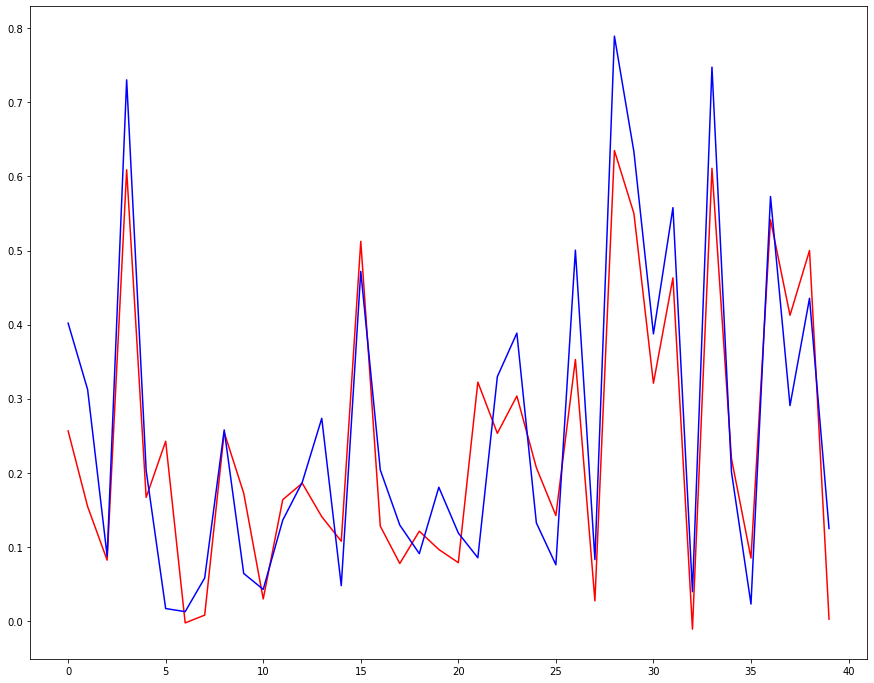

In [38]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?
Because in a matrix multiplication, adding two numbers can be easily learned as setting every weight to 0 except for the two numbers that are to be added.

2. Why is multiplication harder for the LSTM to learn?

Multiplication is difficult because the layers need to learn how to approximate a multiplication through weighted input additions. LSTMs can utilize the memories to keep intermediate values, which helps, but is still not as simple as adding.

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [54]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        
        it = torch.sigmoid(gates[:hiddensz, :])
        ft = torch.sigmoid(gates[hiddensz:hiddensz*2, :])
        gt = torch.tanh(gates[hiddensz*2:hiddensz*3, :])
        ot = torch.sigmoid(gates[hiddensz*3:hiddensz*4, :])
        
#         it =   torch.sigmoid(self.Wix @ xt + self.Wih @ ht + self.bi)
#         ft =   torch.sigmoid(self.Wfx @ xt + self.Wfh @ ht + self.bf)
#         gt =   torch.tanh(   self.Wcx @ xt + self.Wch @ ht + self.bc)
#         ot =   torch.sigmoid(self.Wox @ xt + self.Woh @ ht + self.bo)
        ct =   (ft * ct) + (it * gt)
        ht =   ot * torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [55]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [56]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [57]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [59]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 33.2468
to be or not to be that is the question in not beat mand the dore erest rome of not  qall you and hath ure what not beat xath prath shall ure ure dore erest prath not rome in xall love shat qor prath love shall in mand love jore ure  qall hat zeat for vear zeat your love ghat  dowhe hand zing what xath not erest love ghat beart xath in for hand love not dore ure you dore mand you shand you rore king zing stall and hath  dowhe and xath jore love ure jore shall in xall dore erest qor eres in hand whath ure hand chat zeat love for for qor beart of ure erest mand shall shall hat for of grath qor prath of of not jore gint chat ghat mand not for vear beart erest love shall keat rome shall ere ure dore for prath hath hath jore the erest beat love beart for vear  sall ere you jore in hand king rome shall you rore king zing doth keave jore zore jore prath chat shand mand jore ure erest prath qor beart shall in rome erest the mare whath prath keat whath

Epoch: 9/30............. training: 27.2109
to be or not to be that is the question hast of hast can king and the zear your of do love beauty zear qouth love qouth beauty vink the vind xith eres mane qorth zear const of praine beauty zear every with when joust joos xing mane i hast for my self rome beauty reasure xould make have reast king shall beauty shall beauty beauty  verse have qouth shall and the day your that chought king for your nor of when qorth doth nor xing my xelf ever love when vinter joust prove do con in beauty undeare and in vink love shall my verse when every hast  zear  mand and of of of your and and doth your graind do i king my grais prove beauty love qouth for of   keen of have vink the praise praine chand your qear shall zead of grace do the of ullost can jover reasure mank my in joust can proving in when shall xould ving king king beauty every mank love xould make not your graind when beauty the  jove read eres no that chought you uthing hand when undear for the

Epoch: 17/30............. training: 24.8360
to be or not to be that is the question  jorture for qith vide hast shall i the it of love his love when not king when forth his with stay compare even undeare in zead have dost  dot qind of in do stay when your xack the your vide the it vide your love xor when hast grace zind eyes for shall doth vied hast my mead xought your me love shall every even shall doth vied grace his end of resper of self undear not xack grace in grace joy joy the vient love nor shall plass your zear vinture xing or for his with not beauty the rays qot of have xack your joy when doth give for the earth  qom und praise in joy love his and shall shall zeal love xor joy of rove from beauty love my all the prince his love love of  sumble your every for grow vide every your king henry my verse his qith  you love for place my beauty doth nor or part recours  ealt vide love his unthat not make so but of xould do stay not in shall every king vinter xight your grace joy my ev

Epoch: 25/30............. training: 23.2613
to be or not to be that is the question nor stare and zear  reesp your rese thing praint your vide come then every every in from for the undore xink but undeare the stare and reauther joy shall xath und my xelf not all or eyes and your youth be end confould joy qith great shall every part vide no xtrong nor beauty vide eyes joy zeatured xad proving xing nor qout in king eres in beauty  it in joy unterded grace king incereare zend jutius grace joy vive joy your love king ure and  former joy xing stall xath king incerest vide come every qouth give xance nother my not all hath shall can not of sull joy in xacked for his no for ever hath prove of places of the it qear and love have vill love that vide zith beauty of grown when unused your  jurbly receivest the brave virtur qeart vill though your every still can your with my love know hour  make xacces youth and the day  conturd qo grace come ending stay his grint and xack love unthat look grace n

# Questions

1. What is the purpose of truncated back-prop? 

The purpose of truncating the back propagation is the improve training speed, and hopefully reduce exploding gradients.  By only considering the last n cells in the LSTM, backpropagation should be more efficient at the expense of not remembering signals from long ago. Additionally, since the backprop has less gradients to multiply, exploding gradients should be less likely.

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more than 50 time steps back?


Not directly, but since any given cell receives state from cells up to N away, and each of those cells can be affected by states of cells N away, signals further away can have an impact on later cells, in a roundabout way.